Solving 33.jpg (4x4)...
Computing compatibility matrices...
Strategy: Beam Search
Accuracy: 12.50% (2/16 pieces)


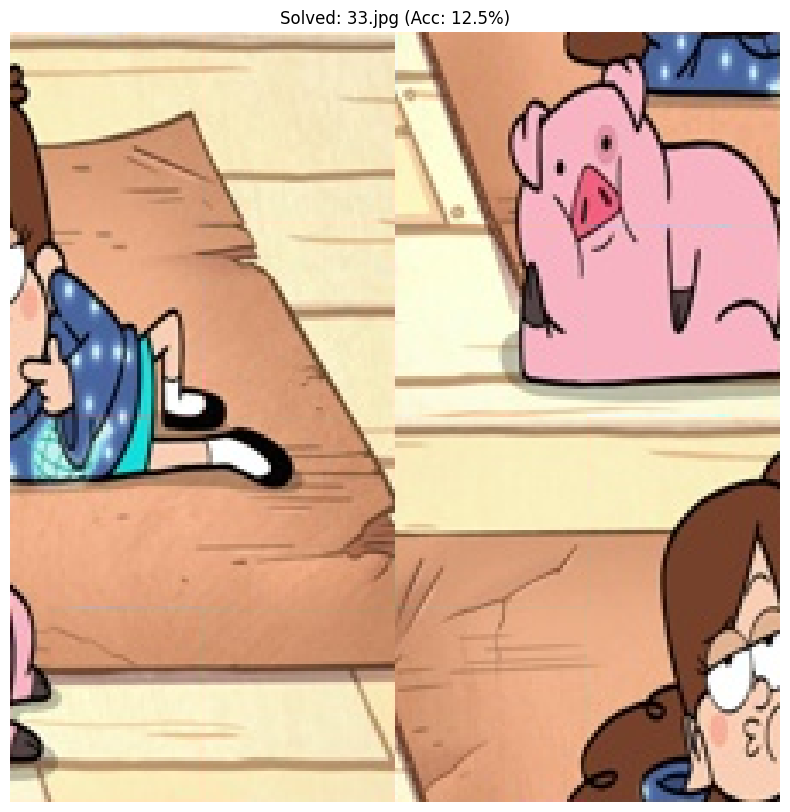

Saved result to results\4x4\33.jpg


In [1]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import heapq
import random
import itertools

# --- 1. Feature Extraction & Similarity Metric ---

def extract_borders(img):
    """
    Extracts the 4 borders of a puzzle piece image.
    Returns a dictionary with keys 'top', 'bottom', 'left', 'right'.
    """
    h, w, _ = img.shape
    return {
        'top': img[0, :, :],      # Shape (w, 3)
        'bottom': img[-1, :, :],  # Shape (w, 3)
        'left': img[:, 0, :],     # Shape (h, 3)
        'right': img[:, -1, :]    # Shape (h, 3)
    }

def calculate_nssd(edge_a, edge_b):
    """
    Normalized Sum of Squared Differences (NSSD).
    Score ranges from 0 (dissimilar) to 1 (identical).
    """
    # Ensure same length (handle slight pixel mismatches if any, though usually square)
    if len(edge_a) != len(edge_b):
        min_len = min(len(edge_a), len(edge_b))
        edge_a = edge_a[:min_len]
        edge_b = edge_b[:min_len]
        
    edge_a = edge_a.astype(np.float32)
    edge_b = edge_b.astype(np.float32)
    
    diff = edge_a - edge_b
    norm_diff = np.sum(diff ** 2)
    norm_a = np.sum(edge_a ** 2)
    norm_b = np.sum(edge_b ** 2)
    
    epsilon = 1e-6
    score = 1 - (norm_diff / (norm_a + norm_b + epsilon))
    return score

def compute_compatibility_matrices(pieces):
    """
    Computes Horizontal (H) and Vertical (V) compatibility matrices.
    H[i][j] = Similarity(piece_i.right, piece_j.left)
    V[i][j] = Similarity(piece_i.bottom, piece_j.top)
    """
    n = len(pieces)
    H = np.zeros((n, n))
    V = np.zeros((n, n))
    
    borders = [extract_borders(p) for p in pieces]
    
    for i in range(n):
        for j in range(n):
            if i == j: 
                H[i, j] = -1.0
                V[i, j] = -1.0
                continue
            
            # Horizontal: i | j  (i's right matches j's left)
            H[i, j] = calculate_nssd(borders[i]['right'], borders[j]['left'])
            
            # Vertical: i / j (i's bottom matches j's top)
            V[i, j] = calculate_nssd(borders[i]['bottom'], borders[j]['top'])
            
    return H, V

# --- 2. Solvers ---

def calculate_board_score(board, H, V, grid_size):
    """Calculates the total compatibility score of a grid configuration."""
    score = 0.0
    # Horizontal links
    for r in range(grid_size):
        for c in range(grid_size - 1):
            p1 = board[r * grid_size + c]
            p2 = board[r * grid_size + c + 1]
            if p1 is not None and p2 is not None:
                score += H[p1, p2]
                
    # Vertical links
    for r in range(grid_size - 1):
        for c in range(grid_size):
            p1 = board[r * grid_size + c]
            p2 = board[(r + 1) * grid_size + c]
            if p1 is not None and p2 is not None:
                score += V[p1, p2]
    return score

def solve_backtracking(n_pieces, H, V):
    """
    Exact solver for small puzzles (2x2, 3x3).
    Uses recursion with pruning to find the permutation with max score.
    """
    grid_size = int(np.sqrt(n_pieces))
    best_score = -1.0
    best_board = None
    
    # Pre-compute valid candidates to speed up? 
    # For N=3 (9 pieces), 9! = 362k, feasible to just brute force with slight pruning.
    
    used = [False] * n_pieces
    current_board = [None] * n_pieces
    
    def backtrack(idx, current_score):
        nonlocal best_score, best_board
        
        if idx == n_pieces:
            if current_score > best_score:
                best_score = current_score
                best_board = list(current_board)
            return

        r, c = idx // grid_size, idx % grid_size
        
        # Optimization: If current partial score is already too far behind best, prune?
        # (Skipping complex pruning for simplicity on small N)

        for p_id in range(n_pieces):
            if not used[p_id]:
                # Calculate score contribution
                score_inc = 0.0
                valid = True
                
                # Check Left Neighbor
                if c > 0:
                    left_p = current_board[idx - 1]
                    s = H[left_p, p_id]
                    if s < 0.1: valid = False # Hard prune on very bad matches
                    score_inc += s
                
                # Check Top Neighbor
                if r > 0:
                    top_p = current_board[idx - grid_size]
                    s = V[top_p, p_id]
                    if s < 0.1: valid = False
                    score_inc += s
                
                if valid:
                    used[p_id] = True
                    current_board[idx] = p_id
                    backtrack(idx + 1, current_score + score_inc)
                    current_board[idx] = None
                    used[p_id] = False

    backtrack(0, 0.0)
    return best_board

def solve_beam_search(n_pieces, H, V, beam_width=100):
    """
    Beam Search for medium puzzles (4x4, 5x5).
    Maintains top K partial solutions.
    """
    grid_size = int(np.sqrt(n_pieces))
    
    # State: (score, [list_of_placed_piece_ids], set_of_used_ids)
    # Start with empty board
    beam = [(0.0, [], set())] 
    
    for step in range(n_pieces):
        new_beam = []
        r, c = step // grid_size, step % grid_size
        
        for score, board, used in beam:
            # Try adding every unused piece
            for p_id in range(n_pieces):
                if p_id not in used:
                    new_score = score
                    
                    # Check Left
                    if c > 0:
                        left_p = board[-1]
                        new_score += H[left_p, p_id]
                        
                    # Check Top
                    if r > 0:
                        top_p = board[step - grid_size]
                        new_score += V[top_p, p_id]
                    
                    new_board = board + [p_id]
                    new_used = used.copy()
                    new_used.add(p_id)
                    new_beam.append((new_score, new_board, new_used))
        
        # Keep top K
        # Note: heapq is min-heap, so we use nlargest
        beam = heapq.nlargest(beam_width, new_beam, key=lambda x: x[0])
        
        # Print progress
        # if step % 5 == 0: print(f"Step {step}/{n_pieces}, Best Score: {beam[0][0]:.2f}")

    return beam[0][1] # Return board of best state

def solve_greedy_local(n_pieces, H, V):
    """
    Greedy placement followed by Local Optimization (Hill Climbing) for large puzzles (8x8+).
    """
    grid_size = int(np.sqrt(n_pieces))
    
    # --- Phase 1: Greedy Initialization ---
    # Simple raster scan greedy: Place (0,0), then best match for (0,1), etc.
    # Better: Prim's-like expansion? Let's stick to raster scan with beam-width 1 logic for simplicity
    # or just reuse Beam Search with small width (e.g., 10) which is effectively greedy but smarter.
    
    # Let's use a randomized greedy start to avoid getting stuck in one bad seed
    best_greedy_board = None
    best_greedy_score = -1
    
    # Try a few random starts
    for _ in range(5):
        used = set()
        board = [None] * n_pieces
        
        # Pick random seed for (0,0)
        seed = random.randint(0, n_pieces - 1)
        board[0] = seed
        used.add(seed)
        
        current_score = 0
        
        for i in range(1, n_pieces):
            r, c = i // grid_size, i % grid_size
            best_p = -1
            best_inc = -float('inf')
            
            for p in range(n_pieces):
                if p not in used:
                    inc = 0
                    if c > 0: inc += H[board[i-1], p]
                    if r > 0: inc += V[board[i-grid_size], p]
                    
                    if inc > best_inc:
                        best_inc = inc
                        best_p = p
            
            board[i] = best_p
            used.add(best_p)
            current_score += best_inc
            
        if current_score > best_greedy_score:
            best_greedy_score = current_score
            best_greedy_board = board

    board = list(best_greedy_board)
    current_score = best_greedy_score
    
    # --- Phase 2: Local Optimization (Hill Climbing) ---
    # Swap two tiles, check if score improves
    
    max_iter = 10000
    no_improv_limit = 1000
    no_improv = 0
    
    print(f"Starting Local Optimization. Initial Score: {current_score:.2f}")
    
    for it in range(max_iter):
        # Pick two random indices
        idx1, idx2 = random.sample(range(n_pieces), 2)
        
        # Calculate score change
        # We only need to check the neighbors of idx1 and idx2
        
        def get_local_score(idx, p_id):
            r, c = idx // grid_size, idx % grid_size
            s = 0
            # Left
            if c > 0: s += H[board[idx-1], p_id]
            # Right
            if c < grid_size - 1: s += H[p_id, board[idx+1]]
            # Top
            if r > 0: s += V[board[idx-grid_size], p_id]
            # Bottom
            if r < grid_size - 1: s += V[p_id, board[idx+grid_size]]
            return s

        # Score BEFORE swap
        s_before = get_local_score(idx1, board[idx1]) + get_local_score(idx2, board[idx2])
        
        # Perform Swap in temp
        board[idx1], board[idx2] = board[idx2], board[idx1]
        
        # Score AFTER swap
        s_after = get_local_score(idx1, board[idx1]) + get_local_score(idx2, board[idx2])
        
        if s_after > s_before:
            # Keep swap
            current_score += (s_after - s_before)
            no_improv = 0
            # print(f"Iter {it}: Improved to {current_score:.2f}")
        else:
            # Revert swap
            board[idx1], board[idx2] = board[idx2], board[idx1]
            no_improv += 1
            
        if no_improv > no_improv_limit:
            print("Converged.")
            break
            
    return board

# --- 3. Main Pipeline ---

def slice_image(image, n):
    """Slices an image into n x n pieces."""
    h, w, _ = image.shape
    piece_h = h // n
    piece_w = w // n
    pieces = []
    for r in range(n):
        for c in range(n):
            y = r * piece_h
            x = c * piece_w
            piece = image[y:y+piece_h, x:x+piece_w]
            pieces.append(piece)
    return pieces

def solve_puzzle_lab2(image_path, metadata, output_root="results"):
    """
    Solves a puzzle given the image path and metadata containing the grid dimension.
    metadata format: {"filename": "...", "true_label": "2x2", ...}
    """
    # 1. Determine Grid Size
    label = metadata.get("true_label", "2x2")
    try:
        grid_size = int(label.split('x')[0])
    except:
        grid_size = 2
        
    # 2. Load Image
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    full_image = cv2.imread(image_path)
    if full_image is None:
        print("Failed to load image.")
        return
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    
    # 3. Slice Image
    pieces = slice_image(full_image, grid_size)
    n_pieces = len(pieces)
    
    # 4. Shuffle Pieces (to create the puzzle)
    indices = list(range(n_pieces))
    random.shuffle(indices)
    shuffled_pieces = [pieces[i] for i in indices]
    
    # Map: shuffled_index -> original_correct_position
    ground_truth_map = {k: indices[k] for k in range(n_pieces)}
    
    print(f"Solving {os.path.basename(image_path)} ({grid_size}x{grid_size})...")
    
    # 5. Compute Compatibility
    print("Computing compatibility matrices...")
    H, V = compute_compatibility_matrices(shuffled_pieces)
    
    # 6. Select Strategy
    solution_indices = []
    if grid_size <= 3:
        print("Strategy: Exact Backtracking")
        solution_indices = solve_backtracking(n_pieces, H, V)
    elif grid_size <= 5:
        print("Strategy: Beam Search")
        solution_indices = solve_beam_search(n_pieces, H, V, beam_width=200)
    else:
        print("Strategy: Greedy + Local Optimization")
        solution_indices = solve_greedy_local(n_pieces, H, V)
        
    # 7. Evaluate & Visualize
    if not solution_indices:
        print("Failed to find solution.")
        return

    # Calculate Accuracy
    correct_pieces = 0
    for pos, p_id in enumerate(solution_indices):
        if p_id is not None and ground_truth_map[p_id] == pos:
            correct_pieces += 1
    accuracy = (correct_pieces / n_pieces) * 100
    print(f"Accuracy: {accuracy:.2f}% ({correct_pieces}/{n_pieces} pieces)")

    h_p, w_p, _ = pieces[0].shape
    canvas = np.zeros((grid_size * h_p, grid_size * w_p, 3), dtype=np.uint8)
    
    for idx, p_id in enumerate(solution_indices):
        if p_id is None: continue
        r, c = idx // grid_size, idx % grid_size
        canvas[r*h_p:(r+1)*h_p, c*w_p:(c+1)*w_p] = shuffled_pieces[p_id]
        
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(f"Solved: {os.path.basename(image_path)} (Acc: {accuracy:.1f}%)")
    plt.axis('off')
    plt.show()
    
    # Save Result
    if output_root:
        dim_folder = f"{grid_size}x{grid_size}"
        save_dir = os.path.join(output_root, dim_folder)
        os.makedirs(save_dir, exist_ok=True)
        
        filename = os.path.basename(image_path)
        save_path = os.path.join(save_dir, filename)
        
        # Convert RGB back to BGR for OpenCV saving
        canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, canvas_bgr)
        print(f"Saved result to {save_path}")

# Example Usage
solve_puzzle_lab2("data/4x4/33.jpg", {"true_label": "4x4"})

In [ ]:
# --- 4. Batch Evaluation ---
import sys
import os

class SuppressStdout:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def evaluate_solver_batch(dimension, json_file, data_root):
    print(f"\n--- Evaluating {dimension} Puzzles ---")
    
    if not os.path.exists(json_file):
        print(f"JSON file not found: {json_file}")
        return

    with open(json_file, 'r') as f:
        data = json.load(f)
        
    image_list = data['details'] # List of dicts
    source_dir = os.path.join(data_root, dimension)
    
    total_images = 0
    
    # We will just run a few examples to show it works, or run all if user wants
    # Since solve_puzzle_lab2 now prints and shows plots, running 110 images will be too much output.
    # Let's run just 3 random examples per dimension for demonstration.
    
    ##sample_images = random.sample(image_list, min(len(image_list), 3))
    
    for item in image_list:
        filename = item['filename']
        img_path = os.path.join(source_dir, filename)
        
        # Call the updated solver
        # We suppress stdout inside the loop if we want less noise, but user wants to see results.
        # But solve_puzzle_lab2 prints a lot.
        
        print(f"\nProcessing {filename}...")
        try:
            solve_puzzle_lab2(img_path, item)
        except Exception as e:
            print(f"Error: {e}")

# Run Evaluation
data_root = "data"
preprocessed_root = "preprocessed"

evaluate_solver_batch("2x2", os.path.join(preprocessed_root, "2x2_results.json"), data_root)
evaluate_solver_batch("4x4", os.path.join(preprocessed_root, "4x4_results.json"), data_root)
evaluate_solver_batch("8x8", os.path.join(preprocessed_root, "8x8_results.json"), data_root)


--- Evaluating 2x2 Puzzles ---


NameError: name 'json' is not defined

In [2]:
results_2x2 = "results/2x2"
results_4x4 = "results/4x4"
results_8x8 = "results/8x8"
correct = "correct"

results_2x2_images = os.listdir(results_2x2)
results_4x4_images = os.listdir(results_4x4)
results_8x8_images = os.listdir(results_8x8)
correct_images = os.listdir(correct)

In [3]:
import os
import cv2

def load_images_from_folder(folder_path):
    images = []
    image_names = []

    valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")

    for file in sorted(os.listdir(folder_path)):
        if file.lower().endswith(valid_ext):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)

            if img is not None:
                images.append(img)
                image_names.append(file)

    return images, image_names


# Paths
results_2x2 = "results/2x2"
results_4x4 = "results/4x4"
results_8x8 = "results/8x8"
correct = "correct"

# Load images
images_2x2, names_2x2 = load_images_from_folder(results_2x2)
images_4x4, names_4x4 = load_images_from_folder(results_4x4)
images_8x8, names_8x8 = load_images_from_folder(results_8x8)
images_correct, names_correct = load_images_from_folder(correct)

# Example checks
print(f"2x2 images: {len(images_2x2)}")
print(f"4x4 images: {len(images_4x4)}")
print(f"8x8 images: {len(images_8x8)}")
print(f"Correct images: {len(images_correct)}")


2x2 images: 110
4x4 images: 110
8x8 images: 110
Correct images: 110


In [4]:
wrong_count = 0
for i in range(0,110):
    if names_2x2[i] != names_correct[i]:
        wrong_count += 1

wrong_count_4x4 = 0
for i in range(0,110):
    if names_4x4[i] != names_correct[i]:
        wrong_count_4x4 += 1

wrong_count_8x8 = 0
for i in range(0,110):
    if names_8x8[i] != names_correct[i]:
        wrong_count_8x8 += 1

print(f"2x2 Wrongly solved images: {wrong_count} out of 110")
print(f"4x4 Wrongly solved images: {wrong_count_4x4} out of 110")
print(f"8x8 Wrongly solved images: {wrong_count_8x8} out of 110")

2x2 Wrongly solved images: 110 out of 110
4x4 Wrongly solved images: 110 out of 110
8x8 Wrongly solved images: 110 out of 110


In [5]:
names_2x2[46]

'41.jpg'

In [6]:
names_correct[46]

'41.png'

In [7]:
import cv2
import numpy as np

similar = 0
total = len(images_2x2)
mismatched = []

for i in range(total):
    img1 = images_2x2[i]
    img2 = images_correct[i]

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    diff = np.mean(np.abs(img1.astype(np.int16) - img2.astype(np.int16)))

    if diff < 5:
        similar += 1
    else:
        mismatched.append(i)   # store index of mismatched image

print(f"Similar images in 2x2: {similar}/{total}")
percentage = (similar / total) * 100
print(f"{percentage:.2f}%")
print("Mismatched image indices:", mismatched)


Similar images in 2x2: 95/110
86.36%
Mismatched image indices: [29, 31, 34, 35, 37, 42, 46, 47, 48, 49, 64, 84, 85, 86, 108]


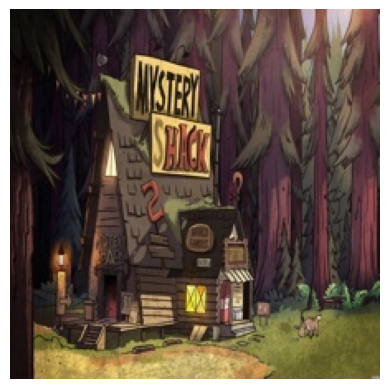

In [9]:
img_rgb = cv2.cvtColor(images_2x2[46], cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

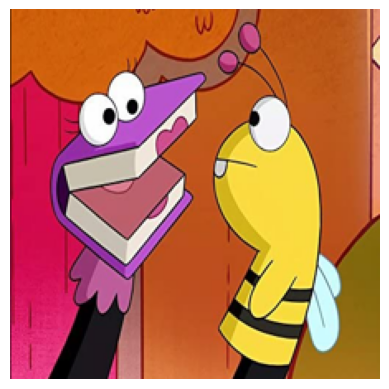

In [10]:
img_rgb = cv2.cvtColor(images_correct[74], cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

46 48 84 85 86

46 48 84 85

In [ ]:
print(100/110*100)

90.9090909090909


In [ ]:
print(94/110*100)

85.45454545454545
